In [1]:
import os
import pandas as pd
import numpy as np
import re
import google.generativeai as genai

from dotenv import load_dotenv # pip install python-dotenv
from utils.experiments import *
from utils.analysis import *
load_dotenv()   # Set API KEY values from .env file


/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Notebook with example of how to run an experiment with a together.ai model

Prerequisites: 

- Make a Together.ai account (https://www.together.ai/), get a Together api key, and put it in a .env file in the root directory of this repo. 
    - in your .env file: TOGETHER_API_KEY="your api key"
- Python requirements: 
    - pip install together python-dotenv pandas numpy scikit-learn 
- Run all the code before the "Choose Model" markdown cell

Yoou're ready to run experiments! 
You can copy cells in the "run Experiment and Analyze" section, change the model variable to any model string listed on https://docs.together.ai/docs/inference-models, and get running! 

Note: the results_df variable gets rewritten, so the notebook will not be happy if you run cells out of order.

In [2]:
dataset = pd.read_csv("data/ipcc_statements_dataset_original_cleaned_context.csv")
test_set = dataset[dataset["split"]=="test"].copy()
train_set = dataset[dataset["split"]=="train"].copy()

In [3]:
genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))

In [11]:
generation_config = genai.GenerationConfig(
    temperature=0,
)


def query_gemini_model(statement, prompt_fn, model):
    prompt = prompt_fn(statement)

    response =  model.generate_content(prompt, generation_config=generation_config)
    raw_output = response.text

    cleaned_output = extract_confidence(raw_output)
    return pd.Series([raw_output, cleaned_output])

In [12]:
# Query the model. n_sc = number of times to run the experiment, for self-consistency.
# The input dataset will be modified with additional columns containing the results of the experiment.
def run_experiment(dataset, model, n_sc=5, prompt_fn=get_zero_shot_prompt):
    for i in range(1, n_sc+1):
        dataset[[f"raw_output_{i}", f"model_confidence_classification_{i}"]] = dataset["final_statement"].apply(lambda x: query_gemini_model(x, prompt_fn, model))
    return dataset
                                                                                                                   

# Choose model - Gemini Pro

## Run Experiment and Analyze

In [17]:
model_name = "gemini-pro"
model = genai.GenerativeModel(model_name)
results_df = test_set.copy()
results_df = run_experiment(results_df, model, 5, get_zero_shot_prompt) 
results_df.to_csv(f"results/cleaned_dataset/{model_name.replace('/', '-')}_zero_shot_06052024_1.csv")

In [18]:
results_df.tail()

,Unnamed: 0.1,Unnamed: 0,statement_idx,report,page_num,sent_num,original_statement,final_statement,confidence,score,...,raw_output_1,model_confidence_classification_1,raw_output_2,model_confidence_classification_2,raw_output_3,model_confidence_classification_3,raw_output_4,model_confidence_classification_4,raw_output_5,model_confidence_classification_5
8024,8024,295,8024,AR6_WGIII,1827,13,REDD+ can significantly contribute to climate ...,Reducing emissions from deforestation and fore...,high,2,...,high,high,high,high,high,high,high,high,high,high
8056,8056,296,8056,AR6_WGIII,2011,5,But large-scale bioenergy projects with CCS ma...,Large-scale bioenergy projects with carbon cap...,medium,1,...,high,high,high,high,high,high,high,high,high,high
8067,8067,297,8067,AR6_WGIII,2012,8,Refor - estation and forest restoration can ha...,Reforestation and forest restoration can have ...,medium,1,...,high,high,high,high,high,high,high,high,high,high
8086,8086,298,8086,AR6_WGIII,2016,8,BEVs are generally heavier than their ICEV cou...,Battery Electric Vehicles (BEVs) could create ...,low,0,...,medium,medium,medium,medium,medium,medium,medium,medium,medium,medium
8093,8093,299,8093,AR6_WGIII,2058,21,"In addition, for pathways that limit warming t...",For pathways that limit warming to 2°C (>67%) ...,high,2,...,high,high,high,high,high,high,high,high,high,high


In [2]:
results_df = pd.read_csv("results/cleaned_dataset/gemini-pro_zero_shot_06052024_1.csv")
model_classification_col_names = [f"model_confidence_classification_{i}" for i in range(1, 6)]
print_accuracy_slope_bias_metrics(results_df, model_classification_col_names, plot=False, verbose=False)

accuracies [0.45, 0.45, 0.45, 0.45, 0.45]
biases: [0.22999999999999998, 0.22999999999999998, 0.22999999999999998, 0.22999999999999998, 0.22999999999999998]
slopes [0.28545454545454546, 0.28545454545454546, 0.28545454545454546, 0.28545454545454546, 0.28545454545454546]

---------------------------------------------------
Metric, Std Dev:
Accuracy: 45.0 ±0.0
Slope: 0.285 ±0.000
Bias: 0.230 ±0.000



In [4]:
results_df.head()


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,statement_idx,report,page_num,sent_num,original_statement,final_statement,confidence,...,raw_output_1,model_confidence_classification_1,raw_output_2,model_confidence_classification_2,raw_output_3,model_confidence_classification_3,raw_output_4,model_confidence_classification_4,raw_output_5,model_confidence_classification_5
0,3,3,0,3,AR6_WGI,24,2,"Since 1750, increases in CO 2 (47%) and CH 4 (...","Since 1750, increases in CO2 (47%) and CH4 (15...",very high,...,very high,very high,very high,very high,very high,very high,very high,very high,very high,very high
1,42,42,1,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...","Over the next 2000 years, global mean sea leve...",low,...,high,high,high,high,high,high,high,high,high,high
2,77,77,2,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...","By the end of the century, scenarios with very...",high,...,high,high,high,high,high,high,high,high,high,high
3,81,81,3,81,AR6_WGI,62,2,"Over the past millennium, and especially since...","Over the past millennium, and especially since...",medium,...,high,high,high,high,high,high,high,high,high,high
4,86,86,4,86,AR6_WGI,63,8,This paleo context supports the assessment tha...,The paleo context supports the assessment that...,high,...,very high,very high,very high,very high,very high,very high,very high,very high,very high,very high


Macro F1 score: 0.32127903411461345
Weighted F1 score: 0.3807529978671036
Accuracy (total): 0.45
              precision    recall  f1-score   support

        high     0.4456    0.8600    0.5870       100
         low     0.0000    0.0000    0.0000        50
      medium     0.4255    0.4000    0.4124       100
   very high     0.6923    0.1800    0.2857        50

    accuracy                         0.4500       300
   macro avg     0.3909    0.3600    0.3213       300
weighted avg     0.4058    0.4500    0.3808       300

confidence
high         100
medium       100
very high     50
low           50
Name: count, dtype: int64
=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.73
Average scores per category: {'low': 1.24, 'medium': 1.61, 'high': 1.92, 'very high': 2.08}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.8210526315789475
Average scores per category: {'low': 1.4, 'medium': 1.7428571428571429,

/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/kerriewu/opt/anaconda3/envs/climate-llms/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

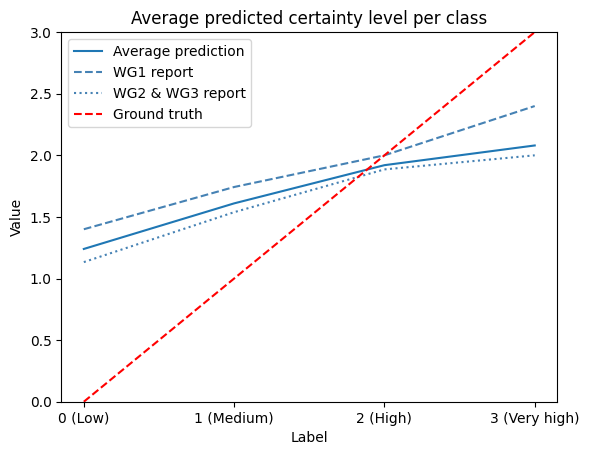

In [5]:
print_metrics(results_df, model_classification_col_names[0])
plot_confidence_assessment(results_df, model_classification_col_names[0])